In [41]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
rng = Random.seed!(0)
N = 100
D = 100
d = 10
σ1 = 1
σ2 = 30
goodpts = 11
X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    X[:,k] = U1*U1'*rand(Uniform(-100,100),D)
end
for j=1:N
        if (j<= goodpts)
            Y[:,j] = X[:,j] + rand(Normal(0,σ1),D)
            Π[j] = σ1^2
        else
            Y[:,j] = X[:,j] + rand(Normal(0,σ2),D)
            Π[j] = σ2^2
        end
end

In [50]:
function HPCA_UNKNOWN_ADMM(Y, λr, N, μ, ρ, U_init)
    X = deepcopy(U_init*U_init'*Y)
    Z = deepcopy(Y-X)
    var = W_NO_GROUPS(Y,X)
    Π = diagm(var.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        var = W_NO_GROUPS(Y,X)
        Π = diagm(var.^-1)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:N]   
    return U, var
end

HPCA_UNKNOWN_ADMM (generic function with 1 method)

In [56]:
using HePPCAT
heppCAT_nogroups = []
for i = 1:N
    push!(heppCAT_nogroups, Y[:,i])
end
U_PPCA = heppcat(heppCAT_nogroups,d,0).U;

In [137]:
function HPCA_APGD(Y, λr, w, N, ϵ, X0)
    Π = w.^-1
    Lf = maximum(Π)
    Π = Diagonal(Π)
    grad = K -> -1*(Y-K)*Π
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    K, _ = pogm_restart(X0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ, mom=:fpgm, restart=:gr) # objective(x,Y-x,λr,w)
    return K
end
function AltMin(Y, λr, N, ϵ)
    Π = ones(size(Y)[2])
    X = zeros(size(Y)) .+ 1
    X0 = zeros(size(Y)) .+ 1e-6
    while norm(X-X0, 2)/norm(X0,2) > 1e-6
        X0 = X
        X = HPCA_POGM(Y, λr, Π, N, ϵ, X)
        Π = W_NO_GROUPS(Y, X)
    end
    return X, Π
end
function W_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)'*(Y-L))
    return max.(Π, 1e-9)
end

W_NO_GROUPS (generic function with 1 method)

In [150]:
UTEST, VAR_ADMM = HPCA_UNKNOWN_ADMM(Y, 100, 10, 0.01, 1.005, U_PPCA);

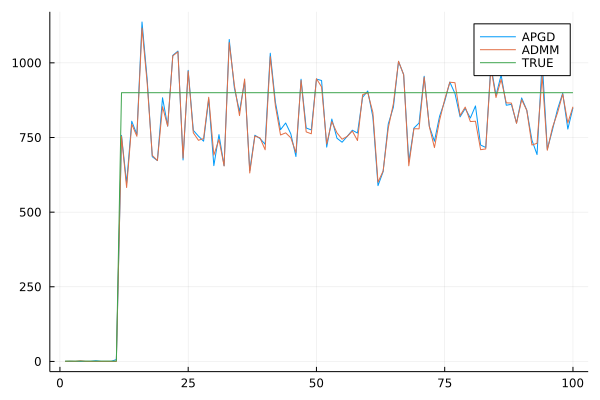

In [158]:
X_HPCA, VTEST = AltMin(Y, 100, 10, 1e-3);
plot(VTEST, label="APGD")
plot!(VAR_ADMM, label="ADMM")
plot!(Π, label="TRUE")

In [157]:
@time begin
  AltMin(Y, 100, 10, 0.2e-2)
end

  6.874914 seconds (100.65 k allocations: 2.884 GiB, 1.93% gc time)


([-20.379597698056614 18.717997882916265 … -47.10610052280907 -4.973421475324903; -7.2133008472028175 14.553317670313156 … -51.64308057643732 1.1373961366773826; … ; 13.761893464887882 6.425622801346693 … 51.601533267603536 25.59389853723345; 4.999529341730698 -16.630622253651445 … -9.977410613548956 2.7220295714220994], [1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 0.4355674783471102, 0.2760574883834456, 3.383076489662483, 0.0031071003342823867, 0.0033896920013734328, 0.5516743359024637  …  819.9167271218474, 727.4100840446564, 532.9537592884075, 963.7056157658996, 614.6713893088614, 809.1531724242678, 816.1443008431035, 851.4730809893933, 770.2837725248198, 859.0636146563717])

In [108]:
@time begin
  HPCA_UNKNOWN_ADMM(Y, 100, 10, 0.01, 1.005, U_PPCA)
end

  7.821692 seconds (205.54 k allocations: 3.179 GiB, 1.90% gc time, 1.52% compilation time)


([-0.12463269599305948 0.03956105310329805 … 0.008253979428597402 -0.01623898237303816; -0.07555503279065834 -0.01315808748845751 … -0.13373453224163107 -0.004559337308998601; … ; 0.0260386236547617 -0.1743476697556499 … 0.018890865222680863 0.3239491485466074; -0.01844492220754795 0.11485636363052462 … 0.12686349872495786 -0.03385782321803714], [1.0e-9, 0.729394249341736, 3.9597569816479694e-8, 2.274518423181442, 2.4033164596381178e-8, 1.1469825495143014e-8, 3.15106465256252e-9, 9.892536770263568e-9, 1.5134296021751067e-9, 3.890131760378128e-9  …  840.9697037347228, 724.8747880695781, 730.4772155560432, 957.2711297047358, 707.2826065208686, 783.1422155200677, 832.9611587509395, 895.5106688001619, 798.6413855336118, 852.9507055481245])